# Tarefa: Previsão do valor total de vendas regressão vídeo game



## Etapa 1: Importação das bibliotecas

In [1]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.__version__

'1.13.1+cu116'

## Etapa 2: Base de dados

In [2]:
torch.manual_seed(123)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base = pd.read_csv('/content/drive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/games.csv')

base = base.drop('Other_Sales', axis = 1)
base = base.drop('Developer', axis = 1)
base = base.drop('NA_Sales', axis = 1)
base = base.drop('EU_Sales', axis = 1)
base = base.drop('JP_Sales', axis = 1)
base = base.drop('Name', axis = 1)

base = base.dropna(axis = 0)

base = base.loc[base['Global_Sales'] > 1]

previsores = base.iloc[:, [0, 1, 2, 3, 5, 6, 7, 8, 9]].values
valor_vendas = base.iloc[:, 4].values

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
onehotencorder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [0, 2, 3, 8])], remainder='passthrough') 
previsores = onehotencorder.fit_transform(previsores).toarray()

previsores = torch.tensor(previsores, dtype = torch.float)
valor_vendas = torch.tensor(valor_vendas, dtype = torch.float).view(-1, 1)

dataset = torch.utils.data.TensorDataset(previsores, valor_vendas)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle = True)

## Etapa 3: Construção do modelo

In [5]:
class regressor_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(99, 50)
        self.dense1 = nn.Linear(50, 50)
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(50, 1)
        
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation(X)
        X = self.dense1(X)
        X = self.activation(X)
        X = self.output(X)
        return X

In [6]:
regressor = regressor_torch()

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

## Etapa 4: Treinamento do modelo

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
regressor.to(device)

regressor_torch(
  (dense0): Linear(in_features=99, out_features=50, bias=True)
  (dense1): Linear(in_features=50, out_features=50, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
for epoch in range(5000):
    
    running_loss = 0.
    running_mse = 0.
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()

        outputs = regressor(inputs)

        mse = F.mse_loss(outputs, labels).item()
        
        running_mse += mse

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        loss = loss.item()
        running_loss += loss

        print('\rÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:06.2f} - MSE {:06.2f}'.format(epoch+1, i+1, len(previsores)//100, loss, mse), end = '\r')

    print('Época %3d finalizada: perda %.5f - MSE %.5f     ' % (epoch+1, running_loss/len(train_loader), running_mse/len(train_loader)))

Época   1 finalizada: perda 20.45546 - MSE 20.45546     
Época   2 finalizada: perda 17.27177 - MSE 17.27177     
Época   3 finalizada: perda 15.27751 - MSE 15.27751     
Época   4 finalizada: perda 15.25613 - MSE 15.25613     
Época   5 finalizada: perda 13.96079 - MSE 13.96079     
Época   6 finalizada: perda 13.64148 - MSE 13.64148     
Época   7 finalizada: perda 13.68728 - MSE 13.68728     
Época   8 finalizada: perda 14.01771 - MSE 14.01771     
Época   9 finalizada: perda 19.54439 - MSE 19.54439     
Época  10 finalizada: perda 14.45552 - MSE 14.45552     
Época  11 finalizada: perda 13.46978 - MSE 13.46978     
Época  12 finalizada: perda 13.45691 - MSE 13.45691     
Época  13 finalizada: perda 13.91856 - MSE 13.91856     
Época  14 finalizada: perda 13.32463 - MSE 13.32463     
Época  15 finalizada: perda 13.40403 - MSE 13.40403     
Época  16 finalizada: perda 13.39674 - MSE 13.39674     
Época  17 finalizada: perda 13.33696 - MSE 13.33696     
Época  18 finalizada: perda 13.

## Etapa 5: Avaliação do modelo

In [11]:
regressor.eval()
previsores = previsores.to(device)
previsoes = regressor(previsores)

In [12]:
previsoes = previsoes.to(torch.device('cpu')).detach().numpy()

In [13]:
previsoes.mean(axis = 0)

array([2.8309805], dtype=float32)

In [14]:
valor_vendas.mean(axis = 0)

tensor([2.8374])

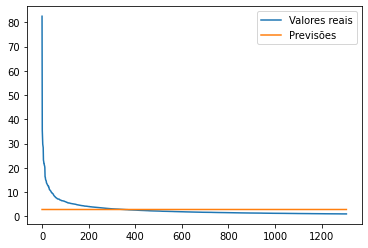

In [15]:
plt.plot(valor_vendas)
plt.plot(previsoes)
plt.legend(['Valores reais', 'Previsões']);